### Libraries and functions

In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso
from tabulate import tabulate
import seaborn as sns
import matplotlib.pyplot as plt
from BorutaShap import BorutaShap
from powershap  import PowerShap
import shapicant
from tqdm import tqdm
from SHAPEffects import FeatureSelector
import random
import shap
import os
import sys
from eli5.sklearn import PermutationImportance
from sklearn.feature_selection import SelectFromModel
os.environ['PYTHONHASHSEED'] = str(1234)
random.seed(1234)
np.random.seed(1234)
plt.style.use('seaborn-whitegrid')
plt.rcParams['font.family'] = 'serif'

C:\Users\csebastian\.conda\envs\BrainEN_v1\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Taken from PowerSHAP paper
def scores_calc_print(Y,Y_pred,print_bool):
    if len(Y_pred) > 1:
        R2_total = r2_score(Y,Y_pred)
    else:
        R2_total = -1
    RMSE_total = mean_squared_error(Y,Y_pred, squared=False)
    MAE_total = mean_absolute_error(Y,Y_pred)
    
    if print_bool:
        print(tabulate([[RMSE_total, MAE_total,R2_total]], ["RMSE","MAE","R²"], tablefmt="grid"))
    else:
        return {"R2":R2_total,"RMSE":RMSE_total,"MAE":MAE_total}

### Data

In [3]:
current_db = pd.read_csv(r"Data/energydata_complete.csv")
# current_db = current_db.reset_index()
current_db['index'] = current_db.index
Index_col = "index"
target_col = "Appliances"

Train-test split

In [4]:
train_idx,test_idx = train_test_split(current_db[Index_col].unique(),test_size=0.25,random_state = 1)
current_db_train = current_db[current_db[Index_col].isin(train_idx)]
train_idx, val_idx = train_test_split(current_db_train[Index_col].unique(),test_size=0.37,random_state = 1)
current_db_val = current_db_train[current_db_train[Index_col].isin(val_idx)]
current_db_train = current_db[current_db[Index_col].isin(train_idx)]
current_db_test = current_db[current_db[Index_col].isin(test_idx)]

In [5]:
current_db_val_test = current_db_val.append(current_db_test)

In [6]:
len(current_db_train), len(current_db_val), len(current_db_test), len(current_db), len(current_db_train) + len(current_db_val) + len(current_db_test)

(9324, 5477, 4934, 19735, 19735)

Modelo con todas las variables

In [8]:
X_train = current_db_train[list(current_db_train.columns.values[2:-1])]
y_train = current_db_train[target_col]

X_val = current_db_val[list(current_db_val.columns.values[2:-1])]
y_val = current_db_val[target_col]

X_test = current_db_test[list(current_db_test.columns.values[2:-1])]
y_test = current_db_test[target_col]

In [10]:
X_train_val = X_train.append(X_val)
y_train_val = y_train.append(y_val)

In [11]:
current_db_train_val = current_db_train.append(current_db_val)

In [12]:
seeds = np.random.randint(1, 999999, 50)

In [13]:
scaler = MinMaxScaler()
scaler_obj = MinMaxScaler()
scaler.fit(X_train)
scaler_obj.fit(y_train.to_numpy().reshape(-1, 1))

X_train_norm = scaler.transform(X_train)
X_val_norm = scaler.transform(X_val)
X_test_norm = scaler.transform(X_test)

y_train_norm = scaler_obj.transform(y_train.to_numpy().reshape(-1, 1)).reshape(len(y_train))
y_val_norm = scaler_obj.transform(y_val.to_numpy().reshape(-1, 1)).reshape(len(y_val))
y_test_norm = scaler_obj.transform(y_test.to_numpy().reshape(-1, 1)).reshape(len(y_test))

## Lasso 0.01

In [14]:
model = Lasso(alpha = 0.01)
model.fit(X_train_norm, y_train_norm)

Lasso(alpha=0.01)

In [15]:
features_lasso_001 = sorted(list(X_train.columns[np.abs(model.coef_) > sys.float_info.epsilon]))
features_lasso_001

[]

In [16]:
# dict_results_lasso_001 = {'rmse':[], 'mae':[], 'r2':[]}

In [17]:
# X_test_lasso_001 = X_test[features_lasso_001]
# X_train_lasso_001= X_train[features_lasso_001]
# X_val_lasso_001 = X_val[features_lasso_001]
# for iteration in range(50):
#     print(iteration)
#     model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=True, random_seed=seeds[iteration])
#     model.fit(
#         X_train_lasso_001, y_train,
#         eval_set=(X_val_lasso_001, y_val),
#         verbose = 0,
#         plot=False
#     );
    
#     test_results = scores_calc_print(y_test, model.predict(X_test_lasso_001), print_bool=False)
    
#     dict_results_lasso_001["r2"].append(test_results["R2"])
#     dict_results_lasso_001["rmse"].append(test_results["RMSE"])
#     dict_results_lasso_001["mae"].append(test_results["MAE"])

In [18]:
# results_lasso_001_df = pd.DataFrame(dict_results_lasso_001)
# mean_lasso_001_test = results_lasso_001_df.mean()
# std_lasso_001_test = results_lasso_001_df.std()
# max_lasso_001_test = results_lasso_001_df.max()
# min_lasso_001_test = results_lasso_001_df.min()

In [19]:
# mean_lasso_001_test, std_lasso_001_test, max_lasso_001_test, min_lasso_001_test

## Lasso 0.001

In [20]:
model = Lasso(alpha = 0.001)
model.fit(X_train_norm, y_train_norm)

Lasso(alpha=0.001)

In [21]:
features_lasso_0001 = sorted(list(X_train.columns[np.abs(model.coef_) > sys.float_info.epsilon]))
features_lasso_0001

['RH_out', 'T3', 'T6', 'Windspeed', 'lights']

In [22]:
dict_results_lasso_0001 = {'rmse':[], 'mae':[], 'r2':[]}

In [23]:
X_test_lasso_0001 = X_test[features_lasso_0001]
X_train_lasso_0001= X_train[features_lasso_0001]
X_val_lasso_0001 = X_val[features_lasso_0001]
for iteration in range(50):
    print(iteration)
    model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=True, random_seed=seeds[iteration])
    model.fit(
        X_train_lasso_0001, y_train,
        eval_set=(X_val_lasso_0001, y_val),
        verbose = 0,
        plot=False
    );
    
    test_results = scores_calc_print(y_test, model.predict(X_test_lasso_0001), print_bool=False)
    
    dict_results_lasso_0001["r2"].append(test_results["R2"])
    dict_results_lasso_0001["rmse"].append(test_results["RMSE"])
    dict_results_lasso_0001["mae"].append(test_results["MAE"])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [24]:
results_lasso_0001_df = pd.DataFrame(dict_results_lasso_0001)
mean_lasso_0001_test = results_lasso_0001_df.mean()
std_lasso_0001_test = results_lasso_0001_df.std()
max_lasso_0001_test = results_lasso_0001_df.max()
min_lasso_0001_test = results_lasso_0001_df.min()

In [25]:
mean_lasso_0001_test, std_lasso_0001_test, max_lasso_0001_test, min_lasso_0001_test

(rmse    92.288391
 mae     50.971419
 r2       0.220799
 dtype: float64,
 rmse    0.231491
 mae     0.178012
 r2      0.003911
 dtype: float64,
 rmse    92.857542
 mae     51.444192
 r2       0.228903
 dtype: float64,
 rmse    91.807521
 mae     50.611726
 r2       0.211164
 dtype: float64)

## Lasso 0.0001

In [26]:
model = Lasso(alpha = 0.0001)
model.fit(X_train_norm, y_train_norm)

Lasso(alpha=0.0001)

In [27]:
features_lasso_00001 = sorted(list(X_train.columns[np.abs(model.coef_) > sys.float_info.epsilon]))
features_lasso_00001

['RH_1',
 'RH_2',
 'RH_3',
 'RH_5',
 'RH_6',
 'RH_7',
 'RH_8',
 'RH_9',
 'T1',
 'T3',
 'T4',
 'T6',
 'T8',
 'T9',
 'Tdewpoint',
 'Visibility',
 'Windspeed',
 'lights',
 'rv1']

In [28]:
dict_results_lasso_00001 = {'rmse':[], 'mae':[], 'r2':[]}

In [29]:
X_test_lasso_00001 = X_test[features_lasso_00001]
X_train_lasso_00001= X_train[features_lasso_00001]
X_val_lasso_00001 = X_val[features_lasso_00001]
for iteration in range(50):
    print(iteration)
    model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=True, random_seed=seeds[iteration])
    model.fit(
        X_train_lasso_00001, y_train,
        eval_set=(X_val_lasso_00001, y_val),
        verbose = 0,
        plot=False
    );
    
    test_results = scores_calc_print(y_test, model.predict(X_test_lasso_00001), print_bool=False)
    
    dict_results_lasso_00001["r2"].append(test_results["R2"])
    dict_results_lasso_00001["rmse"].append(test_results["RMSE"])
    dict_results_lasso_00001["mae"].append(test_results["MAE"])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [30]:
results_lasso_00001_df = pd.DataFrame(dict_results_lasso_00001)
mean_lasso_00001_test = results_lasso_00001_df.mean()
std_lasso_00001_test = results_lasso_00001_df.std()
max_lasso_00001_test = results_lasso_00001_df.max()
min_lasso_00001_test = results_lasso_00001_df.min()

In [31]:
mean_lasso_00001_test, std_lasso_00001_test, max_lasso_00001_test, min_lasso_00001_test

(rmse    82.841637
 mae     43.316147
 r2       0.372149
 dtype: float64,
 rmse    0.322259
 mae     0.223991
 r2      0.004884
 dtype: float64,
 rmse    83.523932
 mae     43.806062
 r2       0.385382
 dtype: float64,
 rmse    81.964587
 mae     42.807206
 r2       0.361774
 dtype: float64)

## Lasso 0.00001

In [32]:
model = Lasso(alpha = 0.00001)
model.fit(X_train_norm, y_train_norm)

Lasso(alpha=1e-05)

In [33]:
features_lasso_000001 = sorted(list(X_train.columns[np.abs(model.coef_) > sys.float_info.epsilon]))
features_lasso_000001

['Press_mm_hg',
 'RH_1',
 'RH_2',
 'RH_3',
 'RH_4',
 'RH_5',
 'RH_6',
 'RH_7',
 'RH_8',
 'RH_9',
 'RH_out',
 'T1',
 'T2',
 'T3',
 'T4',
 'T5',
 'T6',
 'T7',
 'T8',
 'T9',
 'T_out',
 'Tdewpoint',
 'Visibility',
 'Windspeed',
 'lights',
 'rv1']

In [34]:
dict_results_lasso_000001 = {'rmse':[], 'mae':[], 'r2':[]}

In [35]:
X_test_lasso_000001 = X_test[features_lasso_000001]
X_train_lasso_000001= X_train[features_lasso_000001]
X_val_lasso_000001 = X_val[features_lasso_000001]
for iteration in range(50):
    print(iteration)
    model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=True, random_seed=seeds[iteration])
    model.fit(
        X_train_lasso_000001, y_train,
        eval_set=(X_val_lasso_000001, y_val),
        verbose = 0,
        plot=False
    );
    
    test_results = scores_calc_print(y_test, model.predict(X_test_lasso_000001), print_bool=False)
    
    dict_results_lasso_000001["r2"].append(test_results["R2"])
    dict_results_lasso_000001["rmse"].append(test_results["RMSE"])
    dict_results_lasso_000001["mae"].append(test_results["MAE"])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [36]:
results_lasso_000001_df = pd.DataFrame(dict_results_lasso_000001)
mean_lasso_000001_test = results_lasso_000001_df.mean()
std_lasso_000001_test = results_lasso_000001_df.std()
max_lasso_000001_test = results_lasso_000001_df.max()
min_lasso_000001_test = results_lasso_000001_df.min()

In [37]:
mean_lasso_000001_test, std_lasso_000001_test, max_lasso_000001_test, min_lasso_000001_test

(rmse    82.330244
 mae     42.702079
 r2       0.379875
 dtype: float64,
 rmse    0.357084
 mae     0.247437
 r2      0.005380
 dtype: float64,
 rmse    83.281745
 mae     43.233425
 r2       0.391632
 dtype: float64,
 rmse    81.546777
 mae     42.214952
 r2       0.365470
 dtype: float64)

## Boruta

In [38]:
model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=False, random_seed = 123)

# if classification is False it is a Regression problem
Feature_Selector = BorutaShap(model=model,
                              importance_measure='gini',
                              classification=False)

Feature_Selector.fit(X=X_train_val, y=y_train_val, sample=False,
                        train_or_test = 'test', normalize=True,verbose=True)

# 1 minutos 46 segundos

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:17<00:00,  3.90s/it]

24 attributes confirmed important: ['RH_3', 'Tdewpoint', 'RH_out', 'T5', 'T1', 'RH_6', 'RH_7', 'RH_4', 'T9', 'T6', 'T2', 'T8', 'T3', 'lights', 'T4', 'RH_2', 'RH_1', 'RH_8', 'Press_mm_hg', 'RH_5', 'T7', 'Windspeed', 'T_out', 'RH_9']
3 attributes confirmed unimportant: ['rv1', 'Visibility', 'rv2']
0 tentative attributes remains: []


In [39]:
subset = Feature_Selector.Subset()
selected_features_boruta = sorted(subset.columns.values)
selected_features_boruta

['Press_mm_hg',
 'RH_1',
 'RH_2',
 'RH_3',
 'RH_4',
 'RH_5',
 'RH_6',
 'RH_7',
 'RH_8',
 'RH_9',
 'RH_out',
 'T1',
 'T2',
 'T3',
 'T4',
 'T5',
 'T6',
 'T7',
 'T8',
 'T9',
 'T_out',
 'Tdewpoint',
 'Windspeed',
 'lights']

In [40]:
dict_results_boruta = {'rmse':[], 'mae':[], 'r2':[]}

In [41]:
X_test_boruta = X_test[selected_features_boruta]
X_train_boruta = X_train[selected_features_boruta]
X_val_boruta = X_val[selected_features_boruta]
for iteration in range(50):
    print(iteration)
    model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=True, random_seed=seeds[iteration])
    model.fit(
        X_train_boruta, y_train,
        eval_set=(X_val_boruta, y_val),
        verbose = 0,
        plot=False
    );
    
    test_results = scores_calc_print(y_test, model.predict(X_test_boruta), print_bool=False)
    
    dict_results_boruta["r2"].append(test_results["R2"])
    dict_results_boruta["rmse"].append(test_results["RMSE"])
    dict_results_boruta["mae"].append(test_results["MAE"])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [42]:
results_boruta_df = pd.DataFrame(dict_results_boruta)
mean_boruta_test = results_boruta_df.mean()
std_boruta_test = results_boruta_df.std()
max_boruta_test = results_boruta_df.max()
min_boruta_test = results_boruta_df.min()

In [43]:
mean_boruta_test, std_boruta_test, max_boruta_test, min_boruta_test

(rmse    81.848339
 mae     42.239443
 r2       0.387110
 dtype: float64,
 rmse    0.405236
 mae     0.232121
 r2      0.006071
 dtype: float64,
 rmse    82.787452
 mae     42.744082
 r2       0.399485
 dtype: float64,
 rmse    81.018772
 mae     41.709519
 r2       0.372980
 dtype: float64)

## PIMP

In [44]:
model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=False, random_seed = 123)
model = model.fit(
    X_train, y_train,
    verbose = 0,
    plot=False
)

In [45]:
pimp = PermutationImportance(model, cv='prefit').fit(X_val, y_val)

In [46]:
pimp.feature_importances_

array([ 0.0730192 ,  0.14750276,  0.19629666,  0.02332221,  0.24595059,
        0.214292  ,  0.20594123,  0.21560476,  0.07925663,  0.06579435,
        0.06114344,  0.13890411,  0.0906771 ,  0.12133299,  0.05817698,
        0.07795005,  0.07493696,  0.10612082,  0.03632082,  0.02277289,
        0.05740692,  0.03537493,  0.01702146,  0.00650282,  0.0470966 ,
       -0.00030919,  0.00122247])

In [47]:
sel = SelectFromModel(pimp,threshold=None, prefit=True)

In [48]:
sel.transform(X_train).shape

(9324, 10)

In [49]:
selected_features_pimp = sorted(list(X_train.columns[sel.get_support()]))
selected_features_pimp

['RH_1', 'RH_2', 'RH_3', 'RH_6', 'T1', 'T3', 'T4', 'T6', 'T7', 'T9']

In [50]:
dict_results_pimp = {'rmse':[], 'mae':[], 'r2':[]}

In [51]:
X_test_pimp = X_test[selected_features_pimp]
X_train_pimp = X_train[selected_features_pimp]
X_val_pimp = X_val[selected_features_pimp]
for iteration in range(50):
    print(iteration)
    model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=True, random_seed=seeds[iteration])
    model.fit(
        X_train_pimp, y_train,
        eval_set=(X_val_pimp, y_val),
        verbose = 0,
        plot=False
    );
    
    test_results = scores_calc_print(y_test, model.predict(X_test_pimp), print_bool=False)
    
    dict_results_pimp["r2"].append(test_results["R2"])
    dict_results_pimp["rmse"].append(test_results["RMSE"])
    dict_results_pimp["mae"].append(test_results["MAE"])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [52]:
results_pimp_df = pd.DataFrame(dict_results_pimp)
mean_pimp_test = results_pimp_df.mean()
std_pimp_test = results_pimp_df.std()
max_pimp_test = results_pimp_df.max()
min_pimp_test = results_pimp_df.min()

In [53]:
mean_pimp_test, std_pimp_test, max_pimp_test, min_pimp_test

(rmse    85.533628
 mae     45.179332
 r2       0.330682
 dtype: float64,
 rmse    0.332803
 mae     0.211039
 r2      0.005197
 dtype: float64,
 rmse    86.216908
 mae     45.517751
 r2       0.350127
 dtype: float64,
 rmse    84.282634
 mae     44.563778
 r2       0.319955
 dtype: float64)

# Results

In [54]:
nombres = ['Lasso_0.001', 'Lasso_0.0001', 'Lasso_0.00001', 'Boruta', 'PIMP']

## MAE

In [55]:
resultados_mae_mean = [mean_lasso_0001_test['mae'], mean_lasso_00001_test['mae'], mean_lasso_000001_test['mae'], mean_boruta_test['mae'], mean_pimp_test['mae']]
resultados_mae_std = [std_lasso_0001_test['mae'], std_lasso_00001_test['mae'], std_lasso_000001_test['mae'], std_boruta_test['mae'], std_pimp_test['mae']]
resultados_mae_max = [max_lasso_0001_test['mae'], max_lasso_00001_test['mae'], max_lasso_000001_test['mae'], max_boruta_test['mae'], max_pimp_test['mae']]
resultados_mae_min = [min_lasso_0001_test['mae'], min_lasso_00001_test['mae'], min_lasso_000001_test['mae'], min_boruta_test['mae'], min_pimp_test['mae']]

(40.0, 52.0)

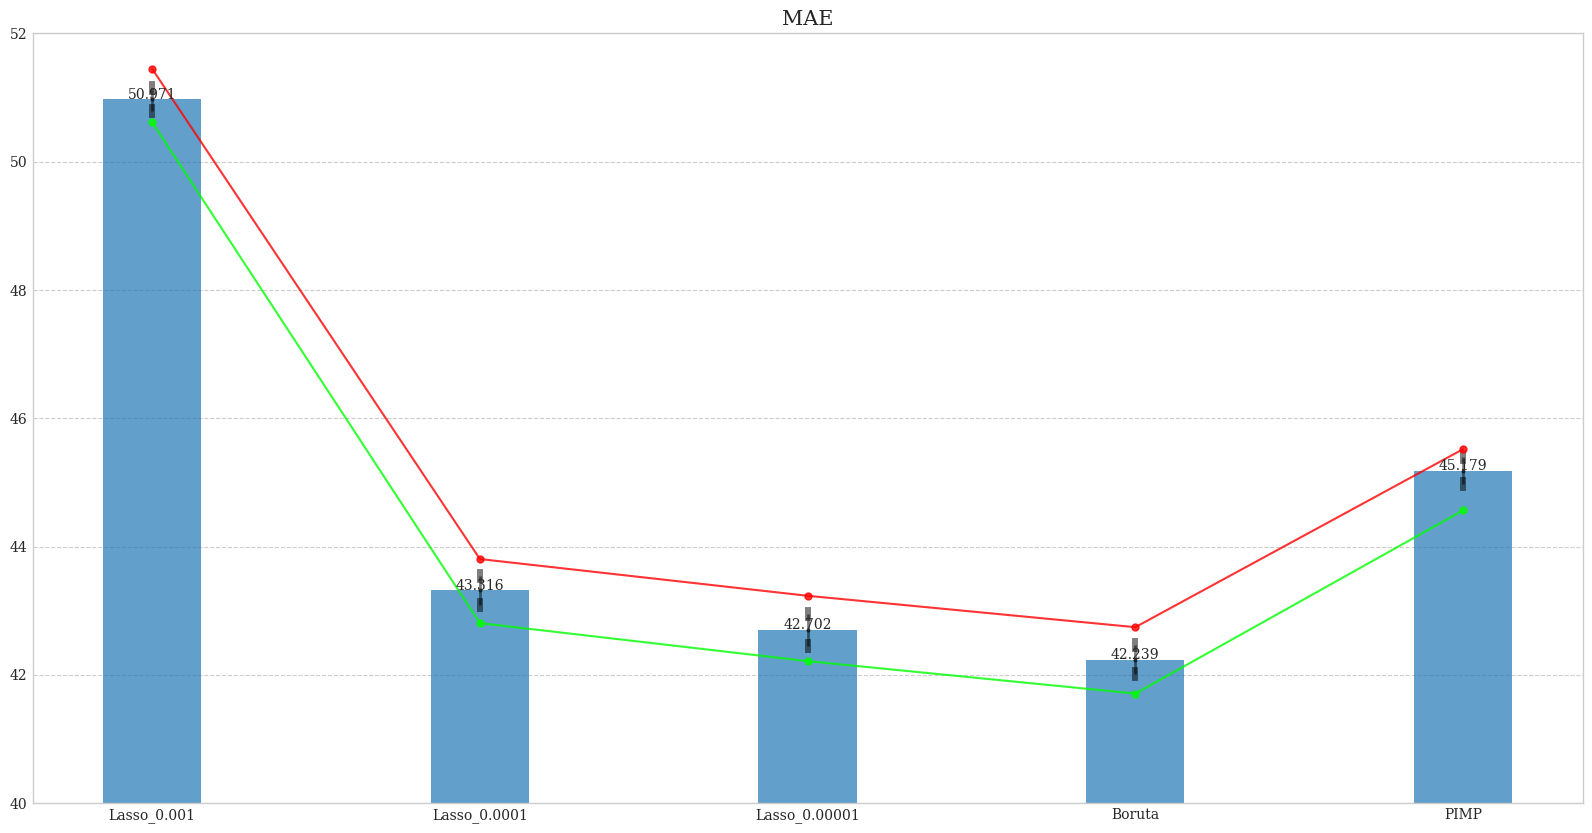

In [56]:
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
ax.bar(nombres, resultados_mae_mean, alpha = 0.7, width=0.3)
ax.errorbar(nombres, resultados_mae_mean, resultados_mae_std, fmt='.', color='Black', elinewidth=2,capthick=10,errorevery=1, alpha=0.5, ms=4, capsize = 2)
ax.plot(nombres, resultados_mae_max, color='red', alpha=0.8, linestyle='-', marker='.', markersize=10)
ax.plot(nombres, resultados_mae_min, color='lime', alpha=0.8, linestyle='-', marker='.', markersize=10)
ax.yaxis.grid(True,linestyle='--')
ax.xaxis.grid(False)
ax.title.set_text("MAE")
ax.title.set_size(15)
for index,data in enumerate(resultados_mae_mean):
    ax.text(x=index , y =data+0.01 , s=f"{round(data, 3)}" , fontdict=dict(fontsize=10), ha='center')
ax.set_ylim([40, 52])

## RMSE

In [57]:
resultados_rmse_mean = [mean_lasso_0001_test['rmse'], mean_lasso_00001_test['rmse'], mean_lasso_000001_test['rmse'], mean_boruta_test['rmse'], mean_pimp_test['rmse']]
resultados_rmse_std = [std_lasso_0001_test['rmse'], std_lasso_00001_test['rmse'], std_lasso_000001_test['rmse'], std_boruta_test['rmse'], std_pimp_test['rmse']]
resultados_rmse_max = [max_lasso_0001_test['rmse'], max_lasso_00001_test['rmse'], max_lasso_000001_test['rmse'], max_boruta_test['rmse'], max_pimp_test['rmse']]
resultados_rmse_min = [min_lasso_0001_test['rmse'], min_lasso_00001_test['rmse'], min_lasso_000001_test['rmse'], min_boruta_test['rmse'], min_pimp_test['rmse']]

(80.0, 94.0)

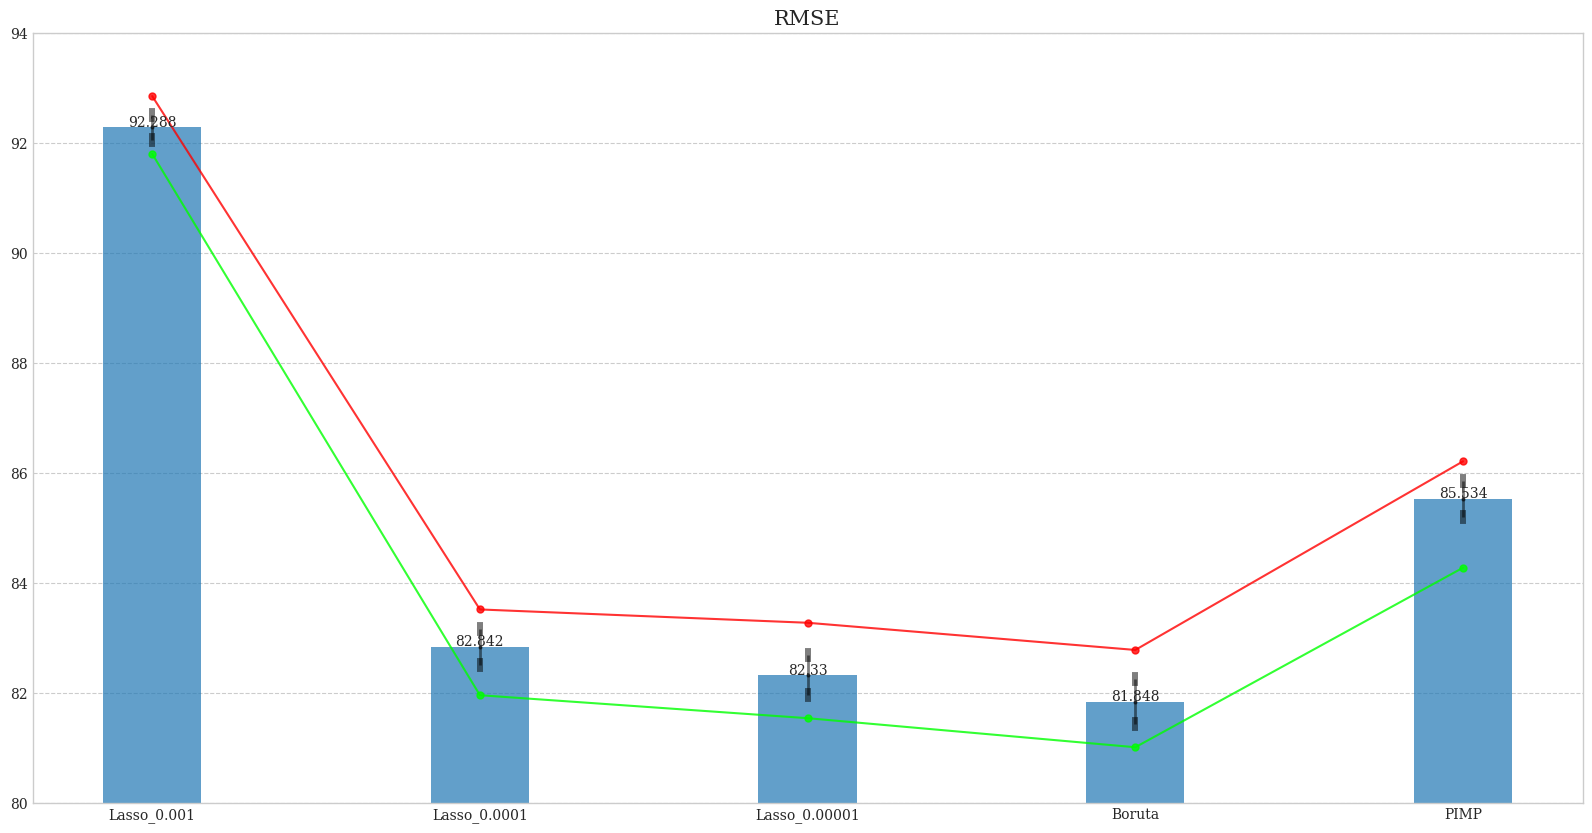

In [58]:
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
ax.bar(nombres, resultados_rmse_mean, alpha = 0.7, width=0.3)
ax.errorbar(nombres, resultados_rmse_mean, resultados_rmse_std, fmt='.', color='Black', elinewidth=2,capthick=10,errorevery=1, alpha=0.5, ms=4, capsize = 2)
ax.plot(nombres, resultados_rmse_max, color='red', alpha=0.8, linestyle='-', marker='.', markersize=10)
ax.plot(nombres, resultados_rmse_min, color='lime', alpha=0.8, linestyle='-', marker='.', markersize=10)
ax.yaxis.grid(True,linestyle='--')
ax.xaxis.grid(False)
ax.title.set_text("RMSE")
ax.title.set_size(15)
for index,data in enumerate(resultados_rmse_mean):
    ax.text(x=index , y =data+0.01 , s=f"{round(data, 3)}" , fontdict=dict(fontsize=10), ha='center')
ax.set_ylim([80, 94])

## R2

In [59]:
resultados_r2_mean = [mean_lasso_0001_test['r2'], mean_lasso_00001_test['r2'], mean_lasso_000001_test['r2'], mean_boruta_test['r2'], mean_pimp_test['r2']]
resultados_r2_std = [std_lasso_0001_test['r2'], std_lasso_00001_test['r2'], std_lasso_000001_test['r2'], std_boruta_test['r2'], std_pimp_test['r2']]
resultados_r2_max = [max_lasso_0001_test['r2'], max_lasso_00001_test['r2'], max_lasso_000001_test['r2'], max_boruta_test['r2'], max_pimp_test['r2']]
resultados_r2_min = [min_lasso_0001_test['r2'], min_lasso_00001_test['r2'], min_lasso_000001_test['r2'], min_boruta_test['r2'], min_pimp_test['r2']]

In [60]:
resultados_r2_max, resultados_r2_min

([0.22890296182982817,
  0.3853823545218603,
  0.39163234138817826,
  0.39948504396234763,
  0.3501266754697516],
 [0.21116371037411252,
  0.36177417535579626,
  0.3654700167204773,
  0.37297978593329784,
  0.3199553973368042])

(0.0, 0.45)

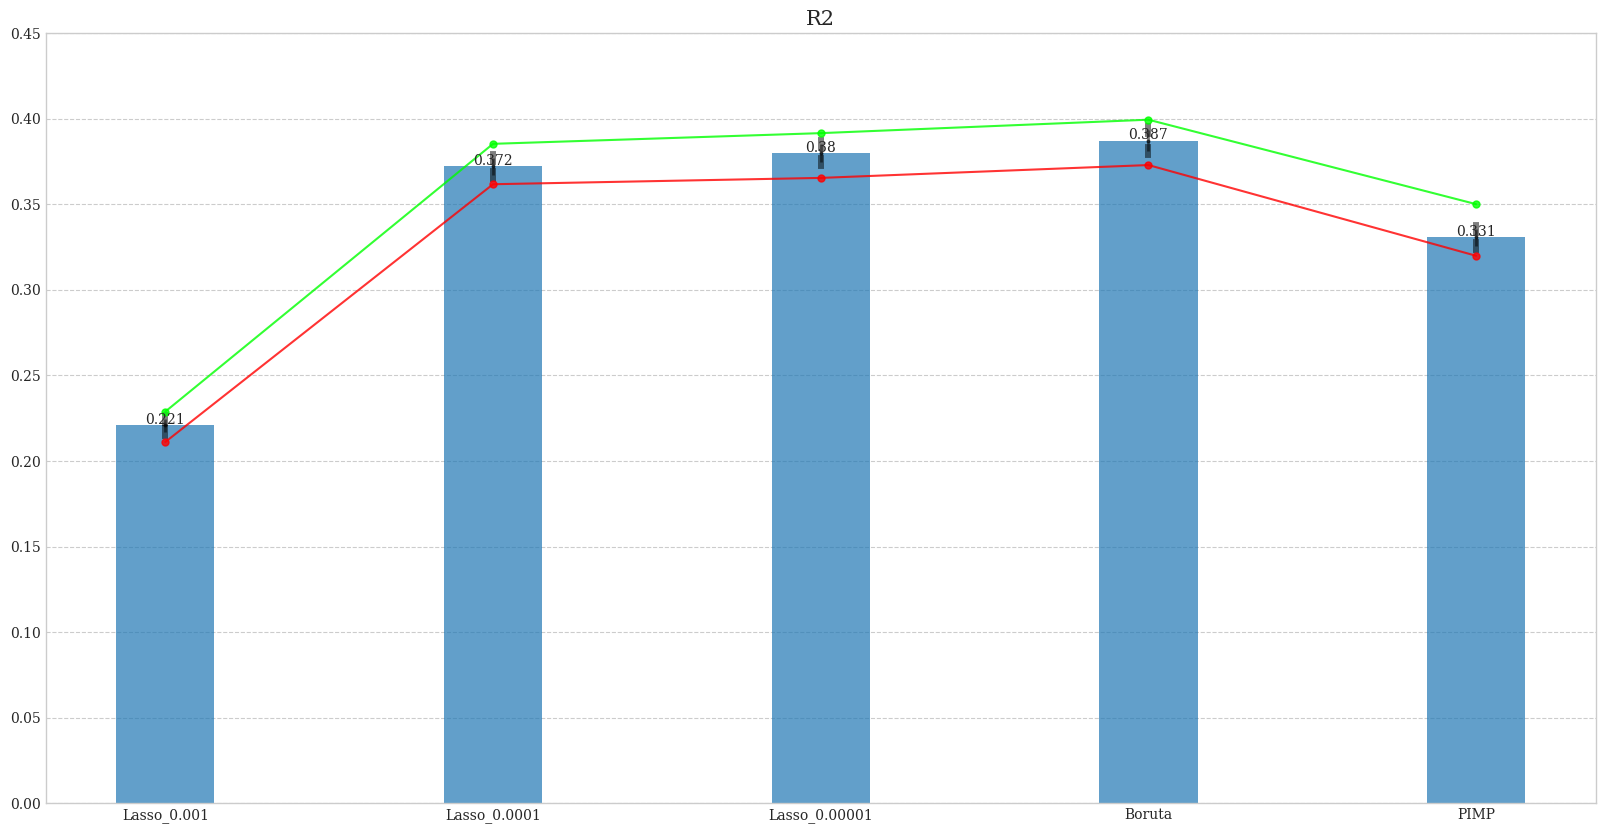

In [61]:
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
ax.bar(nombres, resultados_r2_mean, alpha = 0.7, width=0.3)
ax.errorbar(nombres, resultados_r2_mean, resultados_r2_std, fmt='.', color='Black', elinewidth=2,capthick=10,errorevery=1, alpha=0.5, ms=4, capsize = 2)
ax.plot(nombres, resultados_r2_max, color='lime', alpha=0.8, linestyle='-', marker='.', markersize=10)
ax.plot(nombres, resultados_r2_min, color='red', alpha=0.8, linestyle='-', marker='.', markersize=10)
ax.yaxis.grid(True,linestyle='--')
ax.xaxis.grid(False)
ax.title.set_text("R2")
ax.title.set_size(15)
for index,data in enumerate(resultados_r2_mean):
    ax.text(x=index , y =data+0.001 , s=f"{round(data, 3)}" , fontdict=dict(fontsize=10), ha='center')
ax.set_ylim([0, 0.45])

## Number of variables

In [62]:
n_var = [len(features_lasso_0001), len(features_lasso_00001), len(features_lasso_000001), len(selected_features_boruta), len(selected_features_pimp)]

(0.0, 28.0)

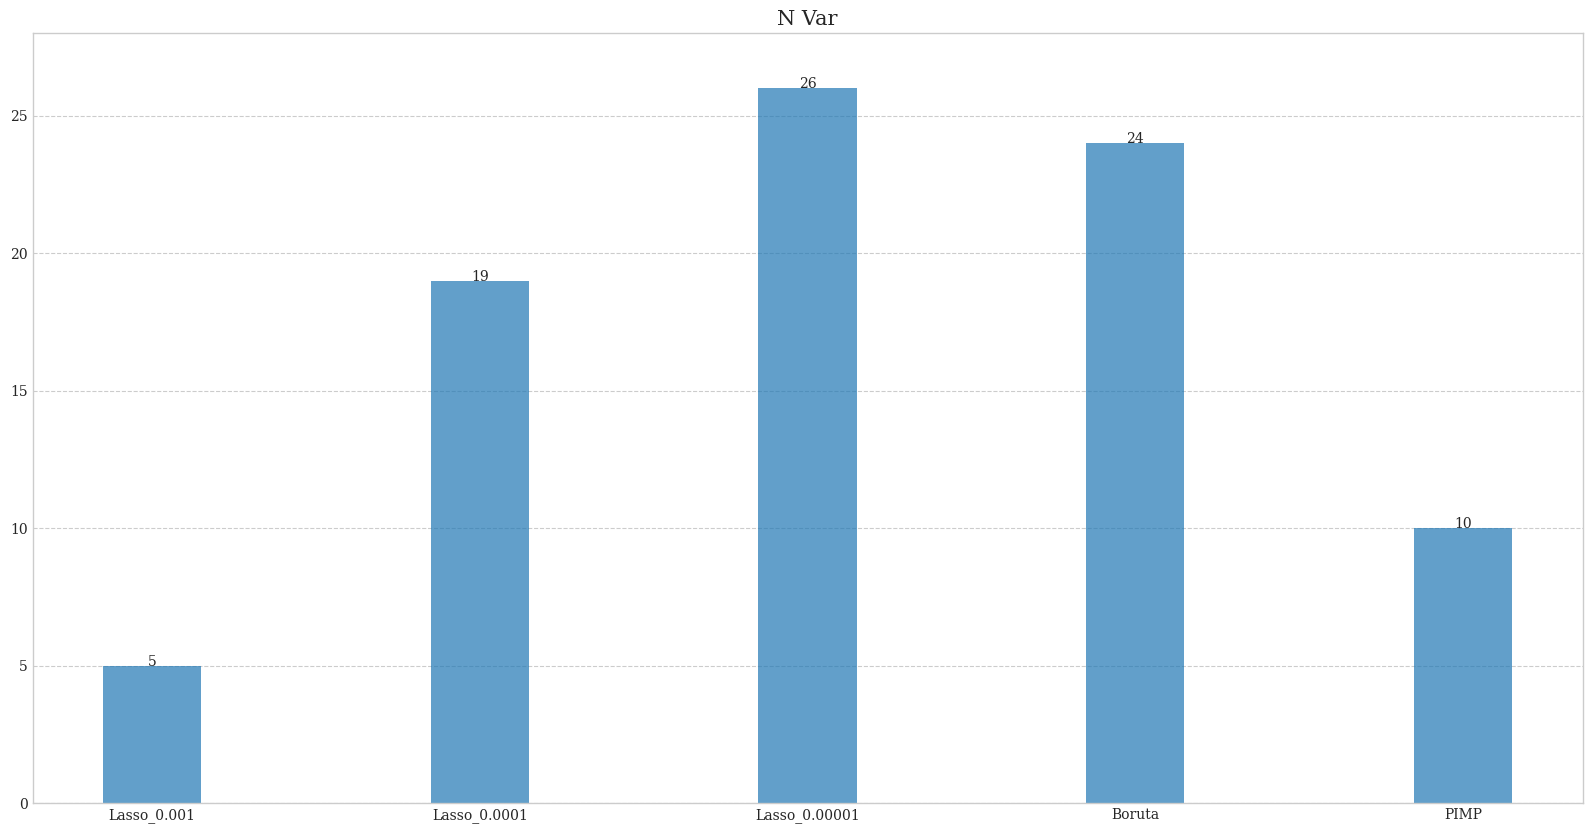

In [63]:
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
bars = ax.bar(nombres, n_var, alpha = 0.7, width=0.3)
ax.yaxis.grid(True,linestyle='--')
ax.xaxis.grid(False)
ax.title.set_text("N Var")
ax.title.set_size(15)
for index,data in enumerate(n_var):
    ax.text(x=index , y =data+0.01 , s=f"{round(data, 3)}" , fontdict=dict(fontsize=10), ha='center')
ax.set_ylim([0, 28])